In [31]:
from typing import List, Dict, Tuple

import warnings

import json
import os
import mimetypes

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.markers as markers

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import MatplotlibDeprecationWarning

In [13]:
# à changer
# %cd ..
%pwd

/content


'/content'

In [15]:
list_dict = []

with os.scandir() as entries:

    for entry in entries:

        if entry.is_file() :

          name = entry.name

          if 'json' in mimetypes.guess_type(name)[0] :

            with open(name, 'r') as file:

              data = json.load(file)

            list_dict.append(data)

In [16]:
list_dict

[{'dataset': 'MUTAG',
  'max_epochs': 200,
  'patience': 20,
  'lr': 0.005,
  'convolution_layer': 'GCN',
  'global_pooling_layer': 'mean',
  'local_pooling_layer': 'SAG',
  'nb_parameters': 9352,
  'mean_accuracy': 0.7456140350877193,
  'std_accuracy': 0.01240538212607982}]

In [19]:
df_homophily = pd.read_csv("/content/homophily_data.csv")
df_homophily['Name_Dataset'] = df_homophily['Name_Dataset'].apply(lambda s : s.upper())
df_homophily.head()

,Name_Dataset,Seed,Homophily_edge_train,Homophily_edge_test,Homophily_node_train,Homophily_node_test,Homophily_edge_insensitive_train,Homophily_edge_insensitive_test
0,MUTAG,12345,0.721,0.722,0.661,0.662,0.034,0.035
1,ENZYMES,12345,0.667,0.660,0.665,0.664,0.370,0.399
2,PROTEINS,12345,0.657,0.654,0.652,0.648,0.372,0.367
3,PATTERN,12345,0.333,0.333,0.333,0.333,0.000,0.000
4,CLUSTER,12345,0.905,0.905,0.901,0.901,0.009,0.000


In [23]:
for dic in list_dict :
  name_dataset = dic["dataset"]
  dic["homophily"] = df_homophily.loc[df_homophily['Name_Dataset'] == name_dataset, 'Homophily_edge_train'].values[0]

In [17]:
test_list_dict = [{'convolution_layer' : 'GCN',
                   'global_pooling_layer' : 'mean-pool',
                   'nb_parameters' : 1000,
                   'mean_accuracy' : 0.5,
                   'homophily' : 0.8,
                   },
                  {'convolution_layer' : 'GRU',
                   'global_pooling_layer' : 'max-pool',
                   'nb_parameters' : 2000,
                   'mean_accuracy' : 0.7,
                   'homophily' : 0.3,
                   }
                  ]

In [33]:
def plot_from_dict(list_dict : List[Dict], figsize : Tuple[int,int]) -> None :
  """
  Plot the graph resulting from the list of dictionnary

  Raises an error if the desired keys are not present in a dictionnary
  """
  # checking that there is no problem of keys in each given dictionnary
  key_values_to_check = ['nb_parameters',
                         'mean_accuracy',
                         'homophily',
                         'global_pooling_layer',
                         'convolution_layer']

  for i,d in enumerate(list_dict) :

    if not(all(key in d for key in key_values_to_check)) :

      raise Exception(f"Problem of key for the {i}-th dictionnary")


  # the x,y and z of the scatter in 3D
  x = np.array([d['nb_parameters'] for d in list_dict])
  y = np.array([d['mean_accuracy'] for d in list_dict])
  z = np.array([d['homophily'] for d in list_dict])


  # the poolings will be used for the color of the points
  poolings = [d['global_pooling_layer'] for d in list_dict]
  unique_poolings = np.unique(poolings)

  # all the colors in matplotlib
  # the functions used is deprecated but works in a simpler way, so we
  # keep it and ignore the deprecation warning
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
    existing_colors = plt.cm.get_cmap('tab10', len(unique_poolings))

  color_mapping = {}
  # creating a dictionnary that maps each value of pooling to a color
  for i, value in enumerate(unique_poolings):
    color_mapping[value] = existing_colors(i)
  # mapping the values through the dictionnary
  colors = [color_mapping[value] for value in poolings]


  # the convolutions will be used for the shape of the points
  convolutions = [d['convolution_layer'] for d in list_dict]

  if len(convolutions) > 41 :
    raise Exception(f"Not enough possible values of shape for the convolutions : got {len(convolutions)} but expected 41 at most")
  # same as for the colors: creating a mapping of the convolutions to the shapes
  unique_convolutions = np.unique(convolutions)
  existing_shapes = list(markers.MarkerStyle.markers.keys())
  shape_mapping = {}

  for i, value in enumerate(unique_convolutions):
    shape_mapping[value] = existing_shapes[i]

  shapes = [shape_mapping[value] for value in convolutions]


  # scatter in 3D
  ax = plt.figure(figsize=figsize).add_subplot(projection='3d')
  plt.tight_layout()

  # the legend for the colors
  colors_keys = list(color_mapping.keys())
  color_values = list(color_mapping.values())
  legend_color = [mpatches.Patch(color=color_values[i], label=f"{colors_keys[i]}-pool") for i in range(len(colors_keys))]

  # the legend for the shapes
  # To do so, a trick: plotting invisible lines for each shape
  shape_keys = list(shape_mapping.keys())
  shape_values = list(shape_mapping.values())
  legend_shape = [ax.scatter([], [], color='black', marker=shape_values[i], label=shape_keys[i]) for i in range(len(shape_keys))]


  for x_value, y_value, z_value, color, shape in zip(x, y, z, colors, shapes) :
    ax.scatter(x_value, y_value, z_value, c=np.array(color).reshape((1,4)), marker=shape)

  ax.legend(handles= legend_color + legend_shape)

  ax.set_xlabel("Number of parameters")
  ax.set_ylabel("Mean accuracy")
  ax.set_zlabel("Homophily", labelpad=0.)

  plt.show()

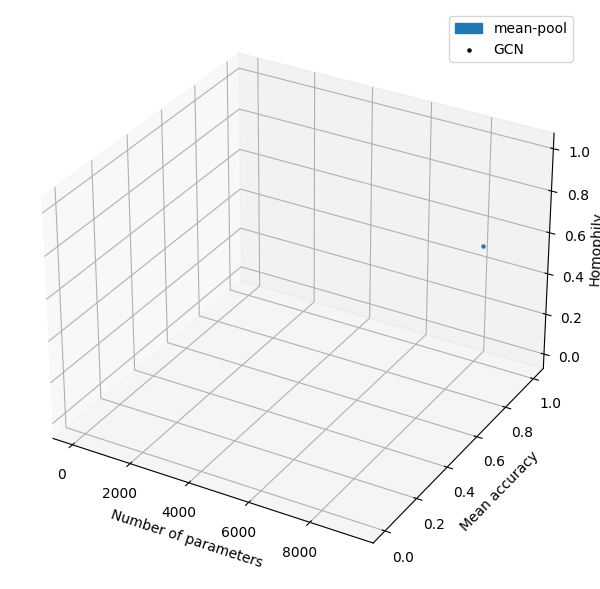

In [34]:
plot_from_dict(list_dict, (6,7));